[334.65618896484375 335.3194885253906 335.43072509765625 335.8722839355469
 336.21929931640625 336.6669921875 337.32476806640625 337.8961181640625
 338.2521057128906 338.73394775390625 337.77679443359375]


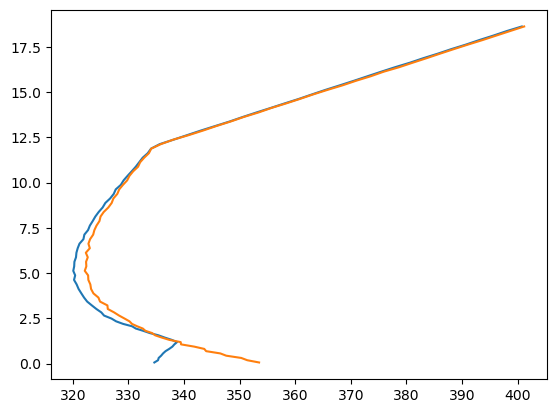

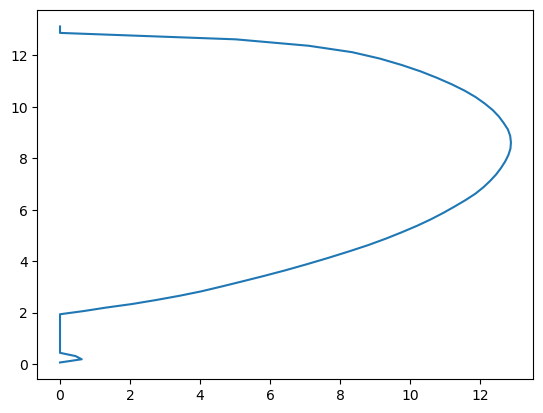

In [47]:
import netCDF4 as nc4
import numpy as np
import matplotlib.pyplot as plt
Cpd = 1005.7  # Heat capacity at constant pressure for dry air [J kg^-1 K^-1]
Cpv = 1870.0  # Heat capacity at constant pressure of water vapor [J kg^-1 K^-1]
Cl = 4190.0   # Heat capacity of liquid water [J kg^-1 K^-1]
Rv = 461.5    # Gas constant of water vapor [J kg^-1 K^-1]
Rd = 287.04   # Gas constant of dry air [J kg^-1 K^-1]
Lv0 = 2.501e6 # Latent heat of vaporization at 0 deg C [J kg^-1]
g = 9.80616  
with nc4.Dataset('outputMorrison/cm1out.nc') as f:
    z=f.variables['zh'][:]
    qv=f.variables['qv'][0,:,:,:]
    th=f.variables['th'][0,:,:,:]
    prs=f.variables['prs'][0,:,:,:]

T=th*(prs/1e5)**(Rd/Cpd)
h=Cpd*T+Lv0*qv#g*z
h_star=Cpd*T
from thermo import q_star
for i in range(z.shape[0]):
    h[i,:,:]=h[i,:,:]+g*z[i]*1e3
    h_star[i,:,:]=h_star[i,:,:]+g*z[i]*1e3
    q_stari=q_star(T[i,:,:],prs[i,:,:])
    h_star[i,:,:]=h_star[i,:,:]+Lv0*q_stari   
#h=Cpd*T+Lv0*q+g*z
#plt.pcolormesh(h[:,5,:])
dh=h[:,5,:].copy()
for i in range(0,h.shape[-1]):
    dh[:,i]=h[:,5,i]-h[:,5,-1]
#plt.plot(h[:,5,-1],z)
#plt.plot(h[:,5,60],z)
#plt.plot(h[:,5,80],z)
#plt.pcolormesh(dh.T,cmap='RdBu_r',vmin=-1e4,vmax=1e4)
#plt.colorbar()
plt.figure()
plt.plot(h[:,5,60]/Cpd,z)
plt.plot(h_star[:,5,80]/Cpd,z)
theta_e=h[:,5,60]/Cpd
print(theta_e[0:11])
from thermo import q_star,destar_dT
t0,qv0,z0=T[0,5,60]+g/Cpd*z[0]*1e3,qv[0,5,60],z[0]
p0=prs[0,5,60]
from thermo import q_star,dqstar_dT
B=np.zeros((64),float)
qv_sat=np.zeros((64),float)
w1d=np.zeros((64),float)
eps=0.15
alpha=1/6.
for i in range(0,64):
    h0=t0+Lv0/Cpd*qv0
    t0=t0*(prs[i,5,60]/p0)**(Rd/Cpd)
    p0=prs[i,5,60]
    q_stari=q_star(t0,prs[i,5,60])
    if(qv0>q_stari):
        dt=Lv0/Cpd*(qv0-q_stari)/(1+Lv0/Cpd*dqstar_dT(prs[i,5,60],t0))
        t01=t0+dt
        q_stari2=q_star(t01,prs[i,5,60])
        qv0=q_stari2
        t0=t01
        #print(t0+Lv0/Cpd*qv0,t01+Lv0/Cpd*q_stari2,dt,q_stari,q_stari2)
        #stop
    qv_sat[i]=qv0
    B[i]=g*(t0-T[i,5,60])/T[i,5,60]
    if i>0:
        w1d[i]=np.sqrt(max(0,w1d[i-1]**2+2*(z[i]-z[i-1])*1000*(alpha*(B[i]+B[i-1])/2)-eps*w1d[i-1]**2))
    #print(i,qv0,q_stari,t0,T[i,5,60],prs[i,5,60])

    #
plt.figure()
plt.plot(w1d,z[:64])

(86,)
0.14616141732283464


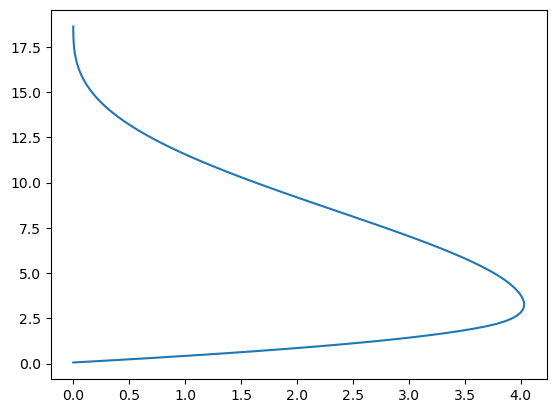

In [48]:
y=np.sin(np.linspace(0,np.pi,86))*(1-np.arange(0,86)/86.)**2
plt.plot(y*10,z[:86])
print(z.shape)
z1d=np.linspace(z[0],z[-1],128)
w1d=np.interp(z1d,z[:],y*10)
#plt.plot(w1d,z1d)
print(z1d[1]-z1d[0])
theta1d=np.interp(z1d,z[:],th[:,5,-1])
qv1d=np.interp(z1d,z[:],qv[:,5,-1])
prs1d=np.interp(z1d,z[:],prs[:,5,-1])
theta1d_0=theta1d.copy()
qv1d_0=qv1d.copy()

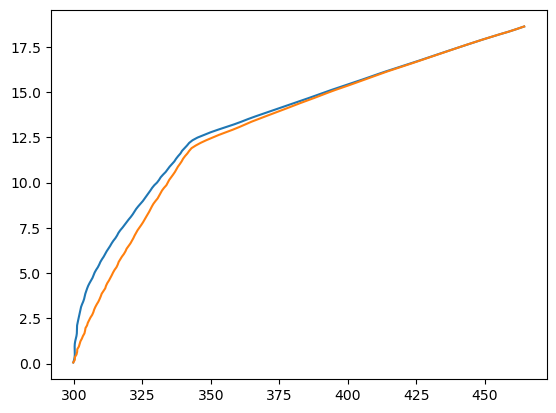

In [49]:
import skid as kid
import matplotlib.pyplot as plt
import numpy as np

nz=128
dt=6 #seconds
dz=(z1d[1]-z1d[0])*1000 #meters
mag=np.sin(np.linspace(0,np.pi,200))

z_old=dz/2+np.arange(0,nz)*dz
import scipy.interpolate as interp
qc1d=np.zeros((nz),float)
for it in range(100):
    #theta1d=kid.laxwendroff(theta1d,w1d*mag[i],dz,dt)
    z_new=z_old+w1d*mag[i]*dt
    csplin=interp.CubicSpline(z_new,theta1d)
    theta1d=csplin(z_old)
    csplin=interp.CubicSpline(z_new,qv1d)
    qv1d=csplin(z_old)
    csplin=interp.CubicSpline(z_new,qc1d)
    qc1d=csplin(z_old)
    for i in range(1,nz-1):
        t0=theta1d*(prs1d[i]/p0)**(Rd/Cpd)
        q_stari=q_star(t0,prs1d[i])
        if(qv1d[i]>q_stari):
            dtemp=Lv0/Cpd*(qv1d-q_stari)/(1+Lv0/Cpd*dqstar_dT(prs1d,t0))
            t0=t0+dtemp
            q_stari=q_star(t0,prs1d[i])
            qc1d[i]=qc1d[i]+(qv1d[i]-q_stari)
            qv1d[i]=q_stari
            theta1d[i]=t0*(p0/prs1d[i])**(Rd/Cpd)
        


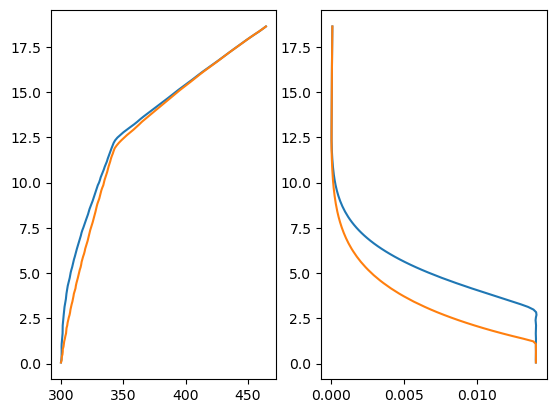

In [51]:
plt.subplot(121)
plt.plot(theta1d,z1d)
plt.plot(theta1d_0,z1d)
plt.subplot(122)
plt.plot(qv1d,z1d)
plt.plot(qv1d_0,z1d)
#print(z_new-z_old)


In [33]:
from PyMPDATA import ScalarField
from PyMPDATA import VectorField
from PyMPDATA.boundary_conditions import Constant
w1df=list(w1d)
w1df.append(0)
w1df=np.array(w1df)
from PyMPDATA import Options
options=Options(n_iters=2)
halo = options.n_halo

advectee = ScalarField(
  data=qv1d_0,
  halo=halo,
  boundary_conditions=(Constant(qv1d_0[0]), Constant(qv1d_0[-1])))

advector = ScalarField(
  data=w1df,
  halo=halo,
  boundary_conditions=(Constant(w1df[0]), Constant(w1df[-1])))

from PyMPDATA import Stepper
stepper = Stepper(options=options, grid=(nz,))

from PyMPDATA import Solver

solver = Solver(stepper=stepper, advectee=advectee, advector=advector)
state_0 = solver.advectee.get().copy()
solver.advance(n_steps=75)
state = solver.advectee.get()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


AssertionError: 

146.16141732283464


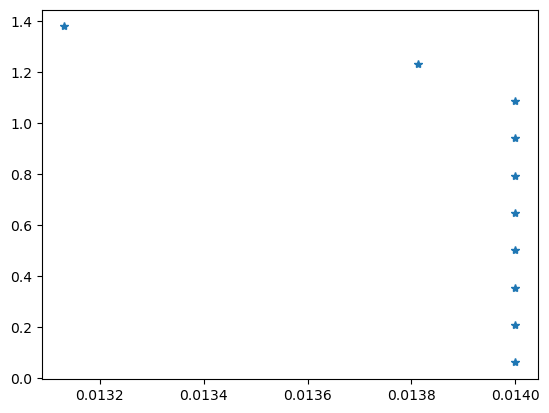

In [8]:
plt.plot(qv1d_0[:10],z1d[:10],'*')
print(dz)

In [ ]:

dx=1.0
x=np.arange(0,nx)*dx
a=np.zeros((nx),float)+0.5
dt=1.
C=np.exp(-(x-60)**2/10**2)
Cs=np.exp(-(x-60)**2/10**2)
plt.plot(C)
for i in range(90):
    C=kid.laxwendroff(C,a,dx,dt)

for i in range(90):
    Cs=kid.upwind(Cs,a,dx,dt)

plt.plot(C)
plt.plot(Cs)